In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import csv
import imageio
from PIL import Image, ImageSequence


plt.rcParams['figure.figsize'] = [16, 4]


In [2]:

nx, ny = 512, 128   # Numer of lattice nodes.
cx, cy, r = nx//6, ny//2, ny//9  # Coordinates of the cylinder.


def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2 < r**2


obstacle = np.fromfunction(obstacle_fun, (nx, ny))

obstacle = obstacle.T


100%|██████████| 20000/20000 [10:19<00:00, 32.28it/s]


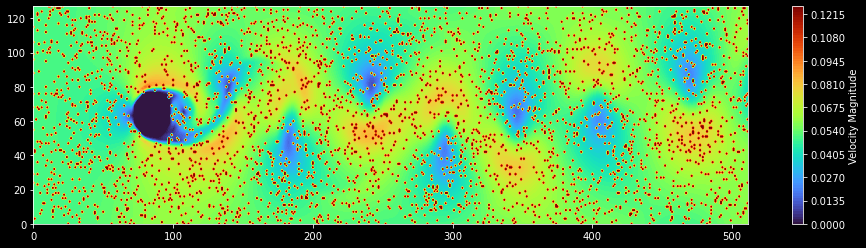

In [16]:

eta = 0.10
maxIter = 2*10**4
for time in tqdm(range(maxIter)):
    if (time % 100 == 0):
        plt.clf()
        U = np.loadtxt(os.path.join('..', 'lbsim cldr', "Original", "csvdata",
                                    "vel.{0:04d}.csv".format(time//100)), delimiter=',')

# Add noise to data

        if eta != 0:
            rep = np.std(U[:])*10
            x = np.random.rand(U[:, :].size)
            b = np.sort(x[:])
            thresh = b[int(np.floor(0.5*eta*b.size))]
            bl = x < thresh
            bl = bl.reshape(ny, nx)

            Un = np.where(bl == False, U, rep)

# clean noise from obstacle
        for i in range(128):
            for j in range(512):
                if obstacle[i, j] == True:
                    Un[i, j] = U[i, j]

        def write_csv(filename):

            f = open(filename, 'w', newline='')
            for velocity in Un:
                csv.writer(f).writerow(velocity)
            f.close()

        write_csv(os.path.join(
            "..", "lbsim cldr", "Noise", "csvdata", "velnoise.{0:04d}.csv".format(time//100)))
        plt.style.use("dark_background")
        plt.contourf(Un, 100, cmap="turbo")
        plt.colorbar().set_label("Velocity Magnitude")
        #plt.gca().add_patch(plt.Circle((cx, cy), r, color="black"))
        plt.savefig(os.path.join(
            "..", "lbsim cldr", "Noise", "imgdata", "velnoise.{0:04d}.png".format(time//100)))


In [22]:
# Function Definitions

def shrink(X, tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y, np.zeros_like(Y))


def SVT(X, tau):
    U, S, VT = np.linalg.svd(X, full_matrices=0)
    out = U @ np.diag(shrink(S, tau)) @ VT
    return out


def RPCA(X):
    n1, n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1, n2))
    thresh = 10**(-7) * np.linalg.norm(X)

    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 10000):
        L = SVT(X-S+(1/mu)*Y, 1/mu)
        S = shrink(X-L+(1/mu)*Y, lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L, S


100%|██████████| 20000/20000 [6:30:05<00:00,  1.17s/it]  


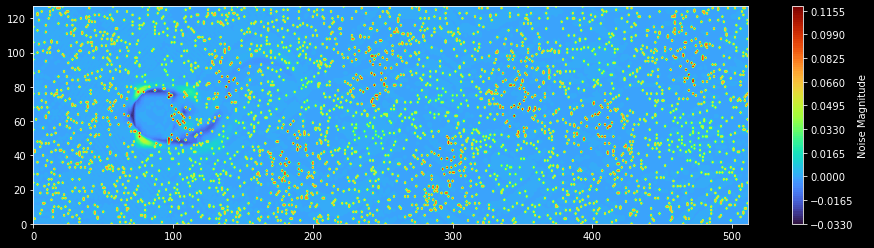

In [24]:
maxIter = 2*10**4
for time in tqdm(range(maxIter)):
    if (time % 100 == 0):
        plt.clf()
        Un = np.loadtxt(os.path.join("..", "lbsim cldr", "Noise", "csvdata",
                                     "velnoise.{0:04d}.csv".format(time//100)), delimiter=',')
        X = Un
        L, S = RPCA(X)

        for i in range(128):
            for j in range(512):
                if obstacle[i, j] == True:
                    L[i, j] = U[i, j]

        def write_csv(filename):

            f = open(filename, 'w', newline='')
            for velocity in L:
                csv.writer(f).writerow(velocity)
            f.close()

        write_csv(os.path.join("..", "lbsim cldr", "Clean", "csvdata",
                               "velclean.{0:04d}.csv".format(time//100)))
        plt.style.use("dark_background")
        plt.contourf(L, 100, cmap="turbo")
        plt.colorbar().set_label("Velocity Magnitude")

        #plt.gca().add_patch(plt.Circle((cx, cy), r, color="black"))
        plt.savefig(os.path.join(
            "..", "lbsim cldr", "Clean", "imgdata", "velclean.{0:04d}.png".format(time//100)))

        plt.clf()
        plt.contourf(S, 100, cmap="turbo")
        plt.colorbar().set_label("Noise Magnitude")
        plt.savefig(os.path.join("..", "lbsim cldr", "Sparse",
                                 "noise.{0:04d}.png".format(time//100)))


In [25]:

path = "/Users/PC/Desktop/Estancia/lbsim cldr/Original/imgdata/"
img = os.listdir(path)

img_array = []

for x in tqdm(range(0, len(img))):
    nom_img = img[x]
    dirimg = path + nom_img

    read_img = imageio.imread(dirimg)

    img_array.append(read_img)

imageio.mimwrite("velocity_fields_original.gif",
                 img_array, "GIF", duration=0.05)


100%|██████████| 200/200 [00:01<00:00, 111.66it/s]


In [26]:
path = "/Users/PC/Desktop/Estancia/lbsim cldr/Noise/imgdata/"
img = os.listdir(path)

img_array = []

for x in tqdm(range(0, len(img))):
    nom_img = img[x]
    dirimg = path + nom_img

    read_img = imageio.imread(dirimg)

    img_array.append(read_img)

imageio.mimwrite("velocity_fields_noisy.gif",
                 img_array, "GIF", duration=0.05)


100%|██████████| 200/200 [00:01<00:00, 109.10it/s]


In [27]:
path = "/Users/PC/Desktop/Estancia/lbsim cldr/Clean/imgdata/"
img = os.listdir(path)

img_array = []

for x in tqdm(range(0, len(img))):
    nom_img = img[x]
    dirimg = path + nom_img

    read_img = imageio.imread(dirimg)

    img_array.append(read_img)

imageio.mimwrite("velocity_fields_cleaned.gif",
                 img_array, "GIF", duration=0.05)


100%|██████████| 200/200 [00:02<00:00, 96.94it/s]


In [3]:
path = "/Users/PC/Desktop/Estancia/lbsim cldr/Sparse/"
img = os.listdir(path)

img_array = []

for x in tqdm(range(0, len(img))):
    nom_img = img[x]
    dirimg = path + nom_img

    read_img = imageio.imread(dirimg)

    img_array.append(read_img)

imageio.mimwrite("Sparse_noise.gif",
                 img_array, "GIF", duration=0.05)


100%|██████████| 200/200 [00:01<00:00, 131.05it/s]


100%|██████████| 20000/20000 [09:28<00:00, 35.19it/s]


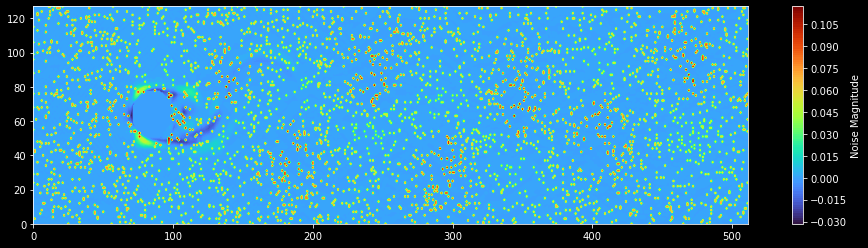

In [11]:
##Creación de imagenes de los resultados del inexact augmented Lagrange multiplier method for Robust PCA.
maxIter = 2*10**4
for time in tqdm(range(maxIter)):
    if (time % 100 == 0):
        plt.clf()
        L = np.loadtxt(os.path.join("..","inalmrpca results", "Cleaned","csvdata",
                                     "Lvelnoise.{0:04d}.csv".format(time//100)), delimiter=',')
        S = np.loadtxt(os.path.join("..", "inalmrpca results", "Sparse", "csvdata",
                                    "Svelnoise.{0:04d}.csv".format(time//100)), delimiter=',')
        for i in range(128):
            for j in range(512):
                if obstacle[i, j] == True:
                    L[i, j] = 0
                    S[i,j] = 0
                    
        def write_csv(filename):

            f = open(filename, 'w', newline='')
            for velocity in L:
                csv.writer(f).writerow(velocity)
            f.close()

        write_csv(os.path.join("..", "inalmrpca results", "Cleaned", "csvdata",
                                     "Lvelnoise.{0:04d}.csv".format(time//100)))
        
        def write_csv(filename):

            f = open(filename, 'w', newline='')
            for velocity in S:
                csv.writer(f).writerow(velocity)
            f.close()

        write_csv(os.path.join("..", "inalmrpca results", "Sparse", "csvdata",
                                     "Svelnoise.{0:04d}.csv".format(time//100)))
        
        plt.style.use("dark_background")
        plt.contourf(L, 100, cmap="turbo")
        plt.colorbar().set_label("Velocity Magnitude")

        #plt.gca().add_patch(plt.Circle((cx, cy), r, color="black"))
        plt.savefig(os.path.join(
            "..", "inalmrpca results", "Cleaned", "imgdata" , "velclean.{0:04d}.png".format(time//100)))
        
        plt.clf()
        plt.style.use("dark_background")
        plt.contourf(S, 100, cmap="turbo")
        plt.colorbar().set_label("Noise Magnitude")

        #plt.gca().add_patch(plt.Circle((cx, cy), r, color="black"))
        plt.savefig(os.path.join(
            "..", "inalmrpca results", "Sparse", "imgdata", "Snoise.{0:04d}.png".format(time//100)))
        


In [12]:
path = "/Users/PC/Desktop/Estancia/inalmrpca results/Cleaned/imgdata/"
img = os.listdir(path)

img_array = []

for x in tqdm(range(0, len(img))):
    nom_img = img[x]
    dirimg = path + nom_img

    read_img = imageio.imread(dirimg)

    img_array.append(read_img)

imageio.mimwrite("Cleaned_inalmrpca.gif",
                 img_array, "GIF", duration=0.05)


100%|██████████| 200/200 [00:02<00:00, 79.33it/s]


In [13]:
path = "/Users/PC/Desktop/Estancia/inalmrpca results/Sparse/imgdata/"
img = os.listdir(path)

img_array = []

for x in tqdm(range(0, len(img))):
    nom_img = img[x]
    dirimg = path + nom_img

    read_img = imageio.imread(dirimg)

    img_array.append(read_img)

imageio.mimwrite("Sparse_inalmrpca.gif",
                 img_array, "GIF", duration=0.05)


100%|██████████| 200/200 [00:02<00:00, 83.21it/s]
